# loading modules

Need to change some pipeline in the sampling process in order to provide DE with a no lib size scVI model

In [1]:
%load_ext autoreload
%autoreload 2
import scVI
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import pickle
from benchmarking import *
import numpy as np
import scipy.stats as stats
from helper import *
import time
from R_interop import IDR
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# parameters

In [2]:
learning_rate = 0.0004
epsilon = 0.01

# import data

In [3]:
# expression data
data_path = "/home/ubuntu/single-cell-scVI/data/10xPBMCs/"
expression_train = np.load(data_path + "de/data_train.npy")
expression_test = np.load(data_path + "de/data_test.npy")

# qc metrics
r_train = np.load(data_path + "design_train.npy")
r_test = np.load(data_path + "design_test.npy")
qc_train = np.load(data_path + "qc_train.npy")
qc_test = np.load(data_path + "qc_test.npy")

# labels
c_train = np.loadtxt(data_path + "label_train")
c_test = np.loadtxt(data_path + "label_test")

# batch info
b_train = np.loadtxt(data_path + "b_train")
b_test = np.loadtxt(data_path + "b_test")

# corrupted data
X_zero, i, j, ix = \
        np.load(data_path + "imputation/X_zero.npy"), np.load(data_path + "imputation/i.npy"),\
        np.load(data_path + "imputation/j.npy"), np.load(data_path + "imputation/ix.npy")
        
#gene info
micro_array_result = pd.read_csv(data_path+"de/gene_info.csv")
gene_names = micro_array_result["ENSG"]
gene_symbols = micro_array_result["GS"]
cd_p_value = micro_array_result["CD_P.Value"]
bdc_p_value = micro_array_result["BDC_P.Value"]
bdc2_p_value = micro_array_result["BDC2_P.Value"]

In [4]:
expression_train.shape, expression_test.shape

((9029, 3346), (3010, 3346))

# Computational graph

In [5]:
tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVINoLibSizeModel(expression=expression, kl_scale=kl_scalar, \
                          optimize_algo=optimizer, phase=training_phase, n_latent=10)

# Session creation
sess = tf.Session()

Running scVI on 3346 genes
scVI will run without batch correction
Will work on mode gene for modeling inverse dispersion param
Will apply zero inflation
1 hidden layers at 128 each for a final 10 latent space


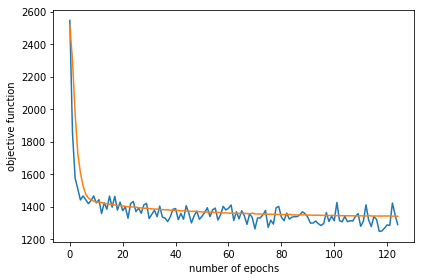

In [6]:
# start a new graph and fit the training set
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
result = train_model(model, (expression_train, expression_test), sess, 125)
#save_path = saver.save(sess, "/tmp/10xPBMCs_DE_125_ep.ckpt")
#print("Model saved in path: %s" % save_path)
plot_training_info(result)
#saver.restore(sess, "/tmp/10xPBMCs_DE_125_ep.ckpt")

# Evaluation methods

### DE

In [13]:
def sample_posterior(model, X, M_z):
    # shape and simulation
    results = {}
    ind = np.arange(X.shape[0])

    # repeat the data for sampling
    X_m = np.repeat(X, M_z, axis=0)
    ind = np.repeat(ind, M_z, axis=0)
        
    #NN part
    dic_x = {expression: X_m, training_phase:False, kl_scalar:1.} 
    z_m = sess.run((model.z), feed_dict=dic_x)
    dic_z = {model.z: z_m, training_phase:False, kl_scalar:1.}
    rate, dropout = sess.run((model.px_rate, model.px_dropout), feed_dict=dic_z)
    dispersion = np.tile(sess.run((tf.exp(model.px_r))), (rate.shape[0], 1))
    
    scale = rate / np.sum(rate, axis=1)[:, np.newaxis]
    
    results["latent"] = z_m
    results["dispersion"] = dispersion
    results["dropout"] = dropout
    results["sample_rate"] = rate
    results["index"] = ind
    return results

In [14]:
def get_sampling(model, subset_a, subset_b, M_z):
    #get q(z| xa) and q(z| xb) and sample M times from it, then output gamma parametrizations
    res_a = sample_posterior(model, expression_train[subset_a], M_z)
    res_b = sample_posterior(model, expression_train[subset_b], M_z)
    return res_a, res_b

In [15]:
def get_statistics(res_a, res_b, M_p=10000, permutation=False):
    """
    Output average over statistics in a symmetric way (a against b)
    forget the sets if permutation is True
    """
    
    #agregate dataset
    samples = np.vstack((res_a["sample_rate"], res_b["sample_rate"]))
    
    # prepare the pairs for sampling
    list_1 = list(np.arange(res_a["sample_rate"].shape[0]))
    list_2 = list(res_a["sample_rate"].shape[0] + np.arange(res_b["sample_rate"].shape[0]))
    if not permutation:
        #case1: no permutation, sample from A and then from B
        u, v = np.random.choice(list_1, size=M_p), np.random.choice(list_2, size=M_p)
    else:
        #case2: permutation, sample from A+B twice
        u, v = (np.random.choice(list_1+list_2, size=M_p), \
                    np.random.choice(list_1+list_2, size=M_p))
    
    # then constitutes the pairs
    first_set = samples[u]
    second_set = samples[v]
    
    res = np.mean(first_set >= second_set, 0)
    res = np.log(res) - np.log(1-res)
    return res

In [20]:
# interest = "CD"
# couple_celltypes = (3, 2)
# rank_auc = 111
# p_prior = 0.03

interest = "BDC"
couple_celltypes = (4, 0)
rank_auc = 800
p_prior = 0.25

In [21]:
# getting p_values
p_value = micro_array_result[interest + "_adj.P.Val"]
signed_p_value = - np.log10(p_value) * np.sign(micro_array_result[interest + "_logFC"])
# setting up parameters
A, B, M_z = 100, 100, 200
set_a = np.where(c_train == couple_celltypes[0])[0]
set_b = np.where(c_train == couple_celltypes[1])[0]

# subsampling cells and computing statistics
subset_a = np.random.choice(set_a, A)
subset_b = np.random.choice(set_b, B)
res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
st = get_statistics(res_a, res_b, M_p=40000)

/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


BDC
Detected  1693  genes with scVI
Detected  879  genes with microarray


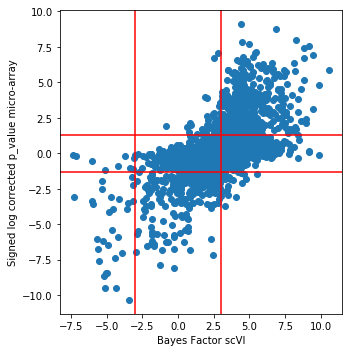

In [22]:
plt.figure(figsize=(5, 5))
plt.scatter(st, signed_p_value)
plt.axvline(x=3, c="r")
plt.axvline(x=-3, c="r")
plt.axhline(y=np.log10(0.05), c="r")
plt.axhline(y=-np.log10(0.05), c="r")
plt.xlabel("Bayes Factor scVI")
plt.ylabel("Signed log corrected p_value micro-array")
plt.tight_layout()
#plt.savefig(interest + "_Bayes_factor_vs_micro_array.pdf", dpi=300)
print interest
print "Detected ", np.sum(2 * np.abs(st) >= 6), " genes with scVI"
print "Detected ", np.sum(p_value <= 0.05), " genes with microarray"

In [23]:
# de evaluation param
idr = IDR.IDR()

l = []
for i in range(20):
    print i
    subset_a = np.random.choice(set_a, A)
    subset_b = np.random.choice(set_b, B)
    res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
    st = get_statistics(res_a, res_b, M_p=40000)
    res = idr.fit(np.abs(st), -np.log(p_value), p_prior=p_prior)
    auc = auc_score_threshold(p_value, np.abs(st), rank_auc, p_value=False)
    res = list(res)
    res.append([auc])
    l.append([x[0] for x in res])    

0


/home/ubuntu/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
